# Kuramoto Model

# Regional Avg

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import os

# Set random seed for consistent results
np.random.seed(42)

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Broad regions and corresponding channels
regions = {
    "frontal": ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
    "temporal": ['T7', 'T8'],
    "parietal": ['CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8'],
    "occipital": ['O1', 'Oz', 'O2']
}

# Load PLV matrix
plv_matrix = np.load("/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Syncronization/plv_matrix.npy")

N = len(regions)  # Number of regions

# Calculate average PLV per region
plv_regions = np.zeros((N, N))
for i, region1 in enumerate(regions.keys()):
    indices1 = [eeg_channel_names.index(ch) for ch in regions[region1]]
    for j, region2 in enumerate(regions.keys()):
        indices2 = [eeg_channel_names.index(ch) for ch in regions[region2]]
        plv_regions[i, j] = np.mean(plv_matrix[np.ix_(indices1, indices2)])

# Set natural frequencies proportional to mean PLV of each region
omega = np.mean(plv_regions, axis=1)

# Phase bias based on mean phase difference between regions
phase_diff_matrix = np.zeros((N, N))
for i, region1 in enumerate(regions.keys()):
    indices1 = [eeg_channel_names.index(ch) for ch in regions[region1]]
    for j, region2 in enumerate(regions.keys()):
        if i != j:
            indices2 = [eeg_channel_names.index(ch) for ch in regions[region2]]
            
            # Compute pairwise phase differences for each combination of channels across the two regions
            pairwise_diffs = []
            for idx1 in indices1:
                for idx2 in indices2:
                    phase_diff = np.angle(hilbert(EEG_data[:, idx1])) - np.angle(hilbert(EEG_data[:, idx2]))
                    pairwise_diffs.append(phase_diff)
            
            # Average over all pairwise differences
            phase_diff_matrix[i, j] = np.mean(pairwise_diffs)
            
# Modify the Kuramoto function to include weighted coupling and phase bias
def kuramoto_weighted_bias(t, y, omega, K):
    weighted_sin = plv_regions * np.sin(y - y[:, np.newaxis] - phase_diff_matrix)
    dydt = omega + K/N * np.sum(weighted_sin, axis=1)
    return dydt

# Hilbert transform to get analytical signal
analytic_signal = hilbert(EEG_data)
phases = np.angle(analytic_signal)

# Average phase for the initial time point for each region
avg_phases = {}
for region, channels in regions.items():
    indices = [eeg_channel_names.index(ch) for ch in channels]
    avg_phases[region] = np.mean(phases[0, indices])

initial_phases = np.array(list(avg_phases.values()))

K = 5.0  # Coupling strength

# Time span for the simulation
t_span = (0, 300)
t_eval = np.linspace(t_span[0], t_span[1], 300) 

# Solve differential equations using the modified model
solution = solve_ivp(kuramoto_weighted_bias, t_span, initial_phases, t_eval=t_eval, args=(omega, K))

# The simulated Kuramoto phases
kuramoto_phases = solution.y

# Create a time axis for plotting
time_axis = np.linspace(t_span[0], t_span[1], 2 * len(EEG_data))

# Interpolating the Kuramoto phases to match the EEG data length
from scipy.interpolate import interp1d
interp_funcs = [interp1d(t_eval, kuramoto_phases[i, :]) for i in range(N)]
kuramoto_phases_interp = np.array([f(time_axis) for f in interp_funcs])

# Plot
plt.figure(figsize=(14, 7))
for i, region in enumerate(regions.keys()):
    plt.plot(time_axis, kuramoto_phases_interp[i, :], label=region, linewidth=1.5)

plt.legend()  # Place legend call here to ensure one entry per region
plt.xlabel('Time')
plt.ylabel('Phase')
plt.title('Simulated Kuramoto Phases for Brain Regions')

save_directory = "/home/vincent/AAA_projects/MVCS/Neuroscience/Modelling/Kuramoto"

# Check if the directory exists and create it if not
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

plot_path = os.path.join(save_directory, "Kuramoto_Brain_Regions_Plot_Extended.png")
plt.savefig(plot_path, dpi=300)  # Increased dpi for better resolution

# Save the simulated Kuramoto phases
kuramoto_data_path = os.path.join(save_directory, "kuramoto_phases_extended.npy")
np.save(kuramoto_data_path, kuramoto_phases)

print(f"Plot saved at {plot_path}")
print(f"Kuramoto phases saved at {kuramoto_data_path}")

plt.show()  # Show the plot at the end

# Granular

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import os

# Set random seed for consistent results
np.random.seed(42)

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Broad regions and corresponding channels
regions = {
    "frontal": ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
    "temporal": ['T7', 'T8'],
    "parietal": ['CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8'],
    "occipital": ['O1', 'Oz', 'O2']
}

# Load PLV matrix
plv_matrix = np.load("/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Syncronization/plv_matrix.npy")

# Number of channels
N = len(eeg_channel_names)

# Set natural frequencies proportional to mean PLV of each channel
omega = np.mean(plv_matrix, axis=1)

# Phase bias based on mean phase difference between channels
phase_diff_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i != j:
            phase_diff = np.mean(np.angle(hilbert(EEG_data[:, i])) - np.angle(hilbert(EEG_data[:, j])))
            phase_diff_matrix[i, j] = phase_diff

# Use initial phases from the EEG data directly, not regions
initial_phases = np.angle(hilbert(EEG_data))[0, :]

# Modify the Kuramoto function to include weighted coupling and phase bias
def kuramoto_weighted_bias(t, y, omega, K):
    weighted_sin = plv_matrix * np.sin(y - y[:, np.newaxis] - phase_diff_matrix)
    dydt = omega + K/N * np.sum(weighted_sin, axis=1)
    return dydt

# Hilbert transform to get analytical signal
analytic_signal = hilbert(EEG_data)
phases = np.angle(analytic_signal)

# Average phase for the initial time point for each region
avg_phases = {}
for region, channels in regions.items():
    indices = [eeg_channel_names.index(ch) for ch in channels]
    avg_phases[region] = np.mean(phases[0, indices])

K = 5.0  # Coupling strength

# Time span for the simulation
t_span = (0, 300)
t_eval = np.linspace(t_span[0], t_span[1], 300) 

# Solve differential equations using the modified model
solution = solve_ivp(kuramoto_weighted_bias, t_span, initial_phases, t_eval=t_eval, args=(omega, K))

# The simulated Kuramoto phases
kuramoto_phases = solution.y

# Create a time axis for plotting
time_axis = np.linspace(t_span[0], t_span[1], 2 * len(EEG_data))

# Interpolating the Kuramoto phases to match the EEG data length
from scipy.interpolate import interp1d
interp_funcs = [interp1d(t_eval, kuramoto_phases[i, :]) for i in range(N)]
kuramoto_phases_interp = np.array([f(time_axis) for f in interp_funcs])

# Plot
plt.figure(figsize=(14, 7))
for i, region in enumerate(regions.keys()):
    plt.plot(time_axis, kuramoto_phases_interp[i, :], label=region, linewidth=1.5)

plt.legend()  # Place legend call here to ensure one entry per region
plt.xlabel('Time')
plt.ylabel('Phase')
plt.title('Simulated Kuramoto Phases for Brain Regions')

save_directory = "/home/vincent/AAA_projects/MVCS/Neuroscience/Modelling/Kuramoto"

# Check if the directory exists and create it if not
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

plot_path = os.path.join(save_directory, "Kuramoto_EEG_Channels_Plot.png")
plt.savefig(plot_path, dpi=300)  # Increased dpi for better resolution

# Save the simulated Kuramoto phases
kuramoto_data_path = os.path.join(save_directory, "kuramoto_phases_channels.npy")
np.save(kuramoto_data_path, kuramoto_phases)

print(f"Plot saved at {plot_path}")
print(f"Kuramoto phases saved at {kuramoto_data_path}")

plt.show()  # Show the plot at the end

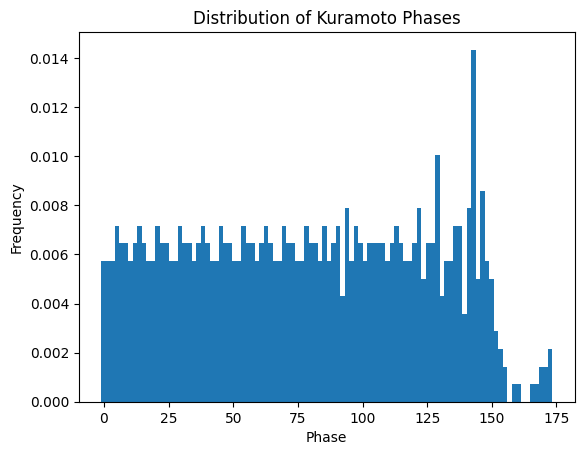

In [14]:
plt.hist(kuramoto_phases.ravel(), bins=100, density=True)
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Distribution of Kuramoto Phases')
plt.show()

# Compare with EEG data

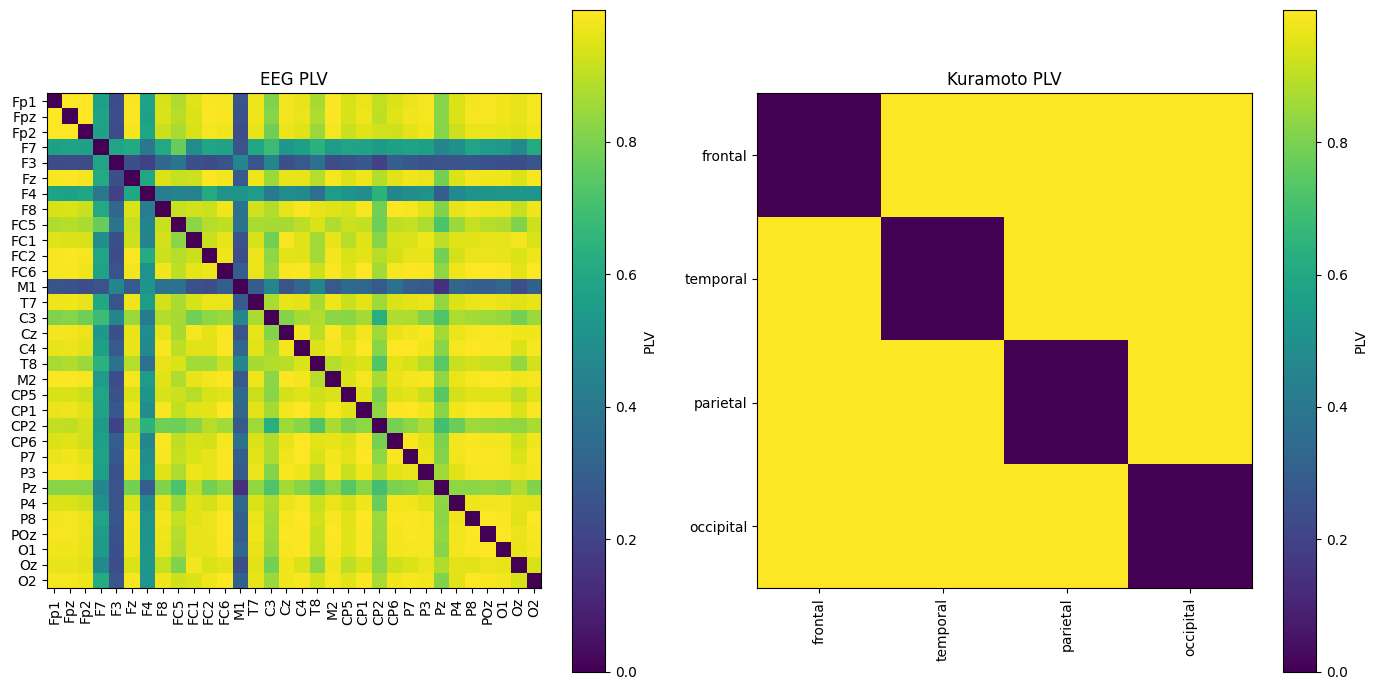

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

def compute_phase_locking_value(signal1, signal2):
    phase1 = np.angle(hilbert(signal1))
    phase2 = np.angle(hilbert(signal2))
    phase_diff = phase1 - phase2
    PLV = abs(np.sum(np.exp(1j * phase_diff))) / len(phase_diff)
    return PLV


# List of EEG channels
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                    'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

num_channels = len(eeg_channel_names)

# Load the precomputed EEG PLVs
eeg_plv_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Syncronization/plv_matrix.npy"
plv_matrix = np.load(eeg_plv_path)

# Compute Kuramoto model channel PLVs
kuramoto_channel_phases = ...  # Assuming you have Kuramoto phase data for each channel
kuramoto_channel_plvs = np.zeros((num_channels, num_channels))
for i in range(num_channels):
    for j in range(num_channels):
        if i != j:
            kuramoto_channel_plvs[i, j] = compute_phase_locking_value(kuramoto_channel_phases[:, i], kuramoto_channel_phases[:, j])

# Visualize channel-wise EEG PLVs and channel-wise Kuramoto PLVs
plt.figure(figsize=(20, 10))

# Plot for real EEG data
plt.subplot(2, 2, 1)
plt.imshow(plv_matrix, cmap="viridis", interpolation="none")
plt.colorbar(label="PLV")
plt.title("EEG Channel PLV")
plt.xticks(np.arange(num_channels), eeg_channel_names, rotation=90)
plt.yticks(np.arange(num_channels), eeg_channel_names)

# Plot for Kuramoto model channel-wise
plt.subplot(2, 2, 2)
plt.imshow(kuramoto_channel_plvs, cmap="viridis", interpolation="none")
plt.colorbar(label="PLV")
plt.title("Kuramoto Channel PLV")
plt.xticks(np.arange(num_channels), eeg_channel_names, rotation=90)
plt.yticks(np.arange(num_channels), eeg_channel_names)

# Assuming you've computed regional Kuramoto PLVs as kuramoto_plv_matrix
plt.subplot(2, 2, 3)
plt.imshow(kuramoto_plv_matrix, cmap="viridis", interpolation="none")
plt.colorbar(label="PLV")
plt.title("Kuramoto Regional PLV")
plt.xticks(np.arange(N), regions.keys(), rotation=90)
plt.yticks(np.arange(N), regions.keys())

plt.tight_layout()
plt.show()

# Feature Extraction

In [ ]:
# Normalization, since phases from the Kuramoto model will be between 0 and 2*pi, 
normalized_phases = kuramoto_phases / (2 * np.pi)

# Feature Creation
instantaneous_frequency = np.vstack([np.zeros(normalized_phases.shape[0]),
                                     np.diff(normalized_phases, axis=1)])

# Combining both the normalized phases and instantaneous frequency for a richer feature set
features = np.vstack([normalized_phases, instantaneous_frequency]).T

# Printing the head (first 5 rows)
print(features[:5])

# Save the features as a .npy file for future use
np.save('/home/vincent/AAA_projects/MVCS/Neuroscience/Modelling/Kuramoto/kuramoto_features.npy', features)


# Bifurcation 

In [ ]:
def compute_order_parameter(phases):
    """Compute the order parameter r from the phases."""
    return np.abs(np.mean(np.exp(1j * phases), axis=0))

# Bifurcation analysis
K_values = np.linspace(0, 5, 50)  # Change the range and number of points as needed
r_values = []

for K in K_values:
    solution = solve_ivp(kuramoto, t_span, initial_phases, t_eval=t_eval, args=(omega, K))
    r = compute_order_parameter(solution.y)
    r_values.append(np.mean(r[-int(desired_length * 0.1):]))  # average of the last 10% to ensure steady-state

# Plot bifurcation diagram
plt.figure(figsize=(12, 6))
plt.plot(K_values, r_values, '-o')
plt.xlabel('Coupling Strength K')
plt.ylabel('Order Parameter r')
plt.title('Bifurcation Diagram of Kuramoto Model')
plt.tight_layout()

bifurcation_plot_path = os.path.join(save_directory, "Kuramoto_Bifurcation_Plot.png")
plt.savefig(bifurcation_plot_path)

print(f"Bifurcation plot saved at {bifurcation_plot_path}")